In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

#Load Data & EDA

In [199]:
import pandas as pd

df = pd.read_csv ("/content/credit_scoring.csv")
df

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
0,501000,41,13995609,5982664,0,624,0,0,-0.040
1,501001,58,13683833,3711198,0,809,0,0,0.001
2,501002,33,9417391,7172332,0,647,0,0,0.077
3,501003,45,6861811,8661056,0,450,0,0,0.038
4,501004,22,5640742,4520669,1,816,0,0,0.020
...,...,...,...,...,...,...,...,...,...
5995,506995,26,18253018,3690565,2,729,0,0,0.008
5996,506996,40,9944385,4082038,1,477,0,0,0.017
5997,506997,28,9048532,14760384,0,450,0,0,-0.054
5998,506998,51,6843160,11774594,0,561,0,0,0.026


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   application_id     6000 non-null   int64  
 1   age                6000 non-null   int64  
 2   monthly_income     6000 non-null   int64  
 3   loan_amount        6000 non-null   int64  
 4   previous_defaults  6000 non-null   int64  
 5   credit_score       6000 non-null   int64  
 6   default            6000 non-null   int64  
 7   leak_col_good      6000 non-null   int64  
 8   leak_col_subtle    6000 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 422.0 KB


In [201]:
df.describe()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
count,6000.000000,6000.000000,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,503999.500000,40.321500,1.140386e+07,8.001122e+06,0.243667,575.979833,0.012167,0.012167,0.011945
std,1732.195139,11.300697,4.912598e+06,4.071786e+06,0.484767,158.328931,0.109639,0.109639,0.113947
min,501000.000000,21.000000,3.000310e+06,1.000794e+06,0.000000,300.000000,0.000000,0.000000,-0.119000
25%,502499.750000,31.000000,7.163379e+06,4.440939e+06,0.000000,438.750000,0.000000,0.000000,-0.020000
50%,503999.500000,41.000000,1.129945e+07,7.982304e+06,0.000000,577.500000,0.000000,0.000000,0.000000
75%,505499.250000,50.000000,1.573705e+07,1.153144e+07,0.000000,713.000000,0.000000,0.000000,0.021000
max,506999.000000,59.000000,1.998622e+07,1.499858e+07,3.000000,849.000000,1.000000,1.000000,1.092000


In [202]:
df.isnull().sum()

,0
application_id,0
age,0
monthly_income,0
loan_amount,0
previous_defaults,0
credit_score,0
default,0
leak_col_good,0
leak_col_subtle,0


In [203]:
df['default'].value_counts()

,count
default,
0,5927
1,73


#Drop leakage columns

In [204]:
df = df.drop(columns=['leak_col_good','leak_col_subtle'])
df

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default
0,501000,41,13995609,5982664,0,624,0
1,501001,58,13683833,3711198,0,809,0
2,501002,33,9417391,7172332,0,647,0
3,501003,45,6861811,8661056,0,450,0
4,501004,22,5640742,4520669,1,816,0
...,...,...,...,...,...,...,...
5995,506995,26,18253018,3690565,2,729,0
5996,506996,40,9944385,4082038,1,477,0
5997,506997,28,9048532,14760384,0,450,0
5998,506998,51,6843160,11774594,0,561,0


#Define Features and Target

In [205]:
feature_names = ['age', 'monthly_income', 'loan_amount', 'previous_defaults', 'credit_score']
X = df[feature_names]
y = df["default"]
application_ids = df["application_id"]

#Scaling & Splitting

In [206]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test, app_id_train, app_id_test = train_test_split(
    X_scaled, y, application_ids, test_size=0.2, stratify=y, random_state=42
)

#Logistic Regression

In [207]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict_proba(X_test)[:, 1]
print("AUC (Logistic Regression):", roc_auc_score(y_test, y_pred_lr))

AUC (Logistic Regression): 0.7552180028129395


#Gradient Boosting Classifier

In [208]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict_proba(X_test)[:, 1]
print("AUC (Gradient Boosting):", roc_auc_score(y_test, y_pred_gb))

AUC (Gradient Boosting): 0.6863009845288326


#Scorecard Function (300–850)

In [209]:
def scorecard(prob):
    return 300 + (prob * 550)

scorecard_preds = scorecard(y_pred_lr)
pd.DataFrame({'Score': scorecard_preds[:5]})

,Score
0,302.386335
1,308.805035
2,300.269583
3,302.949922
4,302.871360


#SHAP Explainability

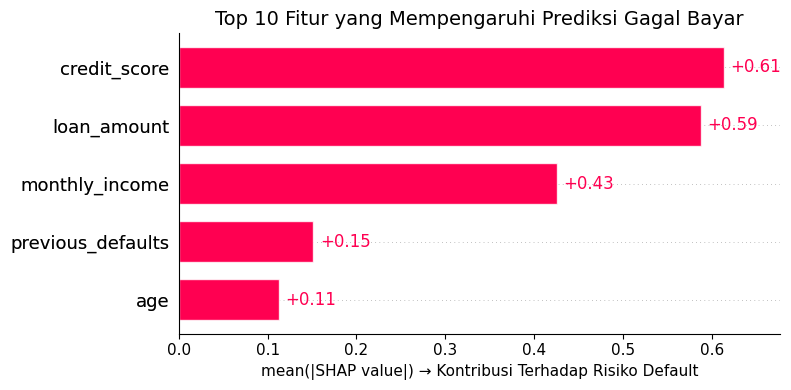

✅ SHAP chart saved: shap_top10.png


In [210]:
explainer = shap.Explainer(gb, X_test)
shap_values = explainer(X_test)
shap_values.feature_names = feature_names

plt.figure(figsize=(10, 5))
shap.plots.bar(shap_values[:, :10], show=False)
plt.title("Top 10 Fitur yang Mempengaruhi Prediksi Gagal Bayar", fontsize=14)
plt.xlabel("mean(|SHAP value|) → Kontribusi Terhadap Risiko Default", fontsize=11)
plt.tight_layout()
plt.show()
plt.savefig("shap_top10.png")
plt.close()
print("✅ SHAP chart saved: shap_top10.png")

#Save Prediction Output

In [211]:
predicted_df = pd.DataFrame({
    "application_id": app_id_test.values,
    "prob_default": y_pred_lr,
    "score": scorecard_preds,
    "actual_default": y_test.values
})

predicted_df.to_csv("predicted_results.csv", index=False)
print("✅ Prediksi disimpan ke: predicted_results.csv")

✅ Prediksi disimpan ke: predicted_results.csv
